In [22]:
import random
import cv2
from matplotlib import pyplot as plt
import albumentations as A

In [9]:
# Example usage
image_path = "C:\\Users\\rowanconverse\\Desktop\\usfws\\images\\test\\BDA_12C_20181127_1.JPG"
labels_path = "C:\\Users\\rowanconverse\Desktop\\usfws\\labels\\test\\BDA_12C_20181127_1.txt"
output_folder = "C:\\Users\\rowanconverse\Desktop\\usfws\\"

In [14]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
   
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

In [12]:
def read_yolo_annotations(file_path):
    labels = []
    bounding_boxes = []

    with open(file_path, 'r') as file:
        for line in file:
            data = line.strip().split()
            label = data[0]
            x_center = float(data[1])
            y_center = float(data[2])
            width = float(data[3])
            height = float(data[4])

            labels.append(label)
            bounding_boxes.append((x_center, y_center, width, height))

    return labels, bounding_boxes


# Usage example
#file_path = 'annotations.txt'  # Replace with the actual file path
category_ids, bboxes = read_yolo_annotations(labels_path)

# Print the extracted lists
print("Labels:")
print(category_ids)
print()
print("Bounding Boxes:")
print(bboxes)


Labels:
['2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '2', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '2', '1', '2']

Bounding Boxes:
[(0.8210891812865497, 0.7565104166666666, 0.017361111111111112, 0.02206688596491228), (0.7970577485380117, 0.7569901315789473, 0.017909356725146198, 0.01206140350877193), (0.6875456871345029, 0.4973273026315789, 0.01343201754385965, 0.019325657894736843), (0.6714181286549707, 0.5211074561403509, 0.016812865497076022, 0.010416666666666666), (0.6782711988304093, 0.5400219298245614, 0.011878654970760233, 0.022478070175438597), (0.6622807017543859, 0.5372807017543859, 0.007309941520467836, 0.021929824561403508), (0.6932108918128655, 0.583744517543

In [26]:
def translate_to_coco_format(bounding_boxes, image_width, image_height):
    coco_boxes = []

    for bbox in bounding_boxes:
        x_center, y_center, width, height = bbox

        x_min = (x_center - width / 2) * image_width
        y_min = (y_center - height / 2) * image_height
        x_max = (x_center + width / 2) * image_width
        y_max = (y_center + height / 2) * image_height

        coco_box = [x_min, y_min, x_max - x_min, y_max - y_min]
        coco_boxes.append(coco_box)

    return coco_boxes

image_width = 5472  # Replace with the actual width of the image
image_height = 3648  # Replace with the actual height of the image

coco_boxes = translate_to_coco_format(bboxes, image_width, image_height)


In [27]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# We will use the mapping from category_id to the class name
# to visualize the class label for the bounding box on the image
category_id_to_name = {'0': 'crane', '1': 'duck', '2': 'goose'}

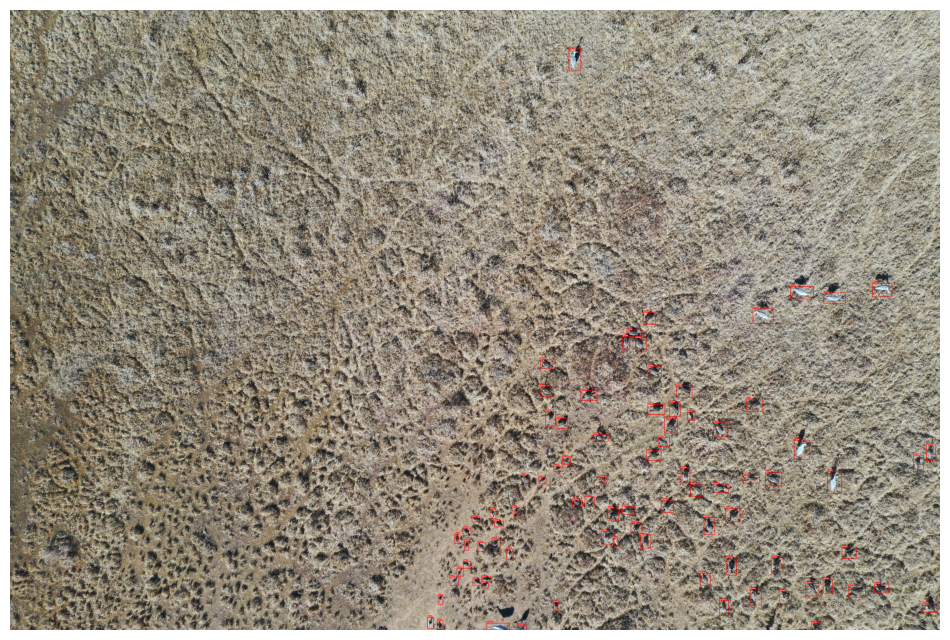

In [28]:
visualize(image, coco_boxes, category_ids, category_id_to_name)

In [10]:


def parse_yolo_boxes(file_path):
    with open(file_path, "r") as file:
        lines = file.readlines()

    boxes = []
    for line in lines:
        label, x_center, y_center, width, height = map(float, line.strip().split(","))
        x_min = (x_center - width / 2)
        y_min = (y_center - height / 2)
        x_max = (x_center + width / 2)
        y_max = (y_center + height / 2)
        boxes.append([x_min, y_min, x_max, y_max])

    return np.array(boxes)

def slice_and_translate(image, boxes, slice_height, slice_width):
    # Convert boxes to absolute coordinates (x_min, y_min, x_max, y_max)
    abs_boxes = np.copy(boxes)
    abs_boxes[:, 0] *= image.shape[1]
    abs_boxes[:, 1] *= image.shape[0]
    abs_boxes[:, 2] *= image.shape[1]
    abs_boxes[:, 3] *= image.shape[0]

    # Slice the image into smaller patches
    patches = []
    slice_transforms = []

    for i in range(0, image.shape[0], slice_height):
        for j in range(0, image.shape[1], slice_width):
            top = i
            left = j
            bottom = min(i + slice_height, image.shape[0])
            right = min(j + slice_width, image.shape[1])

            patch = image[top:bottom, left:right]
            patches.append(patch)

            # Calculate translation parameters for each patch
            tx = -left
            ty = -top
            slice_transforms.append((tx, ty))

    # Update bounding box coordinates for each patch
    transformed_boxes = []

    for patch_boxes, (tx, ty) in zip(abs_boxes, slice_transforms):
        transformed_patch_boxes = np.copy(patch_boxes)
        transformed_patch_boxes[:, 0] += tx
        transformed_patch_boxes[:, 1] += ty
        transformed_patch_boxes[:, 2] += tx
        transformed_patch_boxes[:, 3] += ty
        transformed_boxes.append(transformed_patch_boxes)

    # Concatenate the patches and transformed bounding boxes
    concatenated_image = np.concatenate(patches, axis=1)
    concatenated_boxes = np.concatenate(transformed_boxes, axis=0)

    # Convert bounding box coordinates back to relative values (x_min, y_min, x_max, y_max)
    concatenated_boxes[:, 0] /= concatenated_image.shape[1]
    concatenated_boxes[:, 1] /= concatenated_image.shape[0]
    concatenated_boxes[:, 2] /= concatenated_image.shape[1]
    concatenated_boxes[:, 3] /= concatenated_image.shape[0]

    return concatenated_image, concatenated_boxes

# Example usage
image = cv2.imread(image_path)  # Replace with your image path
boxes = parse_yolo_boxes(labels_path)  # Replace with your .txt file path


# Define the slice size (height and width)
slice_height = 684
slice_width = 521

# Apply the slicing and translation
sliced_image, translated_boxes = slice_and_translate(image, boxes, slice_height, slice_width)

# Show the sliced image with bounding boxes
for box in translated_boxes:
    x_min, y_min, x_max, y_max = box
    x_min = int(x_min * sliced_image.shape[1])
    y_min = int(y_min * sliced_image.shape[0])
    x_max = int(x_max * sliced_image.shape[1])
    y_max = int(y_max * sliced_image.shape[0])
    cv2.rectangle(sliced_image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

cv2.imshow("Sliced Image", sliced_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


ValueError: could not convert string to float: '2 0.8210891812865497 0.7565104166666666 0.017361111111111112 0.02206688596491228'

In [ ]:
def calculate_slice_bboxes(
    image_height: int,
    image_width: int,
    slice_height: int = 512,
    slice_width: int = 512,
    overlap_height_ratio: float = 0.2,
    overlap_width_ratio: float = 0.2,
) -> list[list[int]]:
    """
    Given the height and width of an image, calculates how to divide the image into
    overlapping slices according to the height and width provided. These slices are returned
    as bounding boxes in xyxy format.
    :param image_height: Height of the original image.
    :param image_width: Width of the original image.
    :param slice_height: Height of each slice
    :param slice_width: Width of each slice
    :param overlap_height_ratio: Fractional overlap in height of each slice (e.g. an overlap of 0.2 for a slice of size 100 yields an overlap of 20 pixels)
    :param overlap_width_ratio: Fractional overlap in width of each slice (e.g. an overlap of 0.2 for a slice of size 100 yields an overlap of 20 pixels)
    :return: a list of bounding boxes in xyxy format
    """

    slice_bboxes = []
    y_max = y_min = 0
    y_overlap = int(overlap_height_ratio * slice_height)
    x_overlap = int(overlap_width_ratio * slice_width)
    while y_max < image_height:
        x_min = x_max = 0
        y_max = y_min + slice_height
        while x_max < image_width:
            x_max = x_min + slice_width
            if y_max > image_height or x_max > image_width:
                xmax = min(image_width, x_max)
                ymax = min(image_height, y_max)
                xmin = max(0, xmax - slice_width)
                ymin = max(0, ymax - slice_height)
                slice_bboxes.append([xmin, ymin, xmax, ymax])
            else:
                slice_bboxes.append([x_min, y_min, x_max, y_max])
            x_min = x_max - x_overlap
        y_min = y_max - y_overlap
    return slice_bboxes

In [4]:
image.shape
image_height = image.shape[0]
image_width = image.shape[1]
slice_height: int = 681
slice_width: int = 521
overlap_height_ratio: float = 0.
overlap_width_ratio: float = 0.
slices = calculate_slice_bboxes(image_height,image_width, slice_height, slice_width, overlap_height_ratio, overlap_width_ratio)
slices
slice_index = 3
xmin, ymin, xmax, ymax = slices[slice_index]
show_image(image[ymin:ymax, xmin:xmax])

In [5]:
import albumentations as A

crop_transform = A.Compose(
    [A.Crop(*slices[slice_index]),],
    bbox_params = A.BboxParams(format="yolo",
                               label_fields=['labels'],
                               min_visibility = 0.01
                               min_area=0.01),
)
transformed = crop_transform(image=image, bboxes=bboxes, labels=class_labels)
show_image(transformed['image'], transformed['bboxes'], transformed['labels'])

